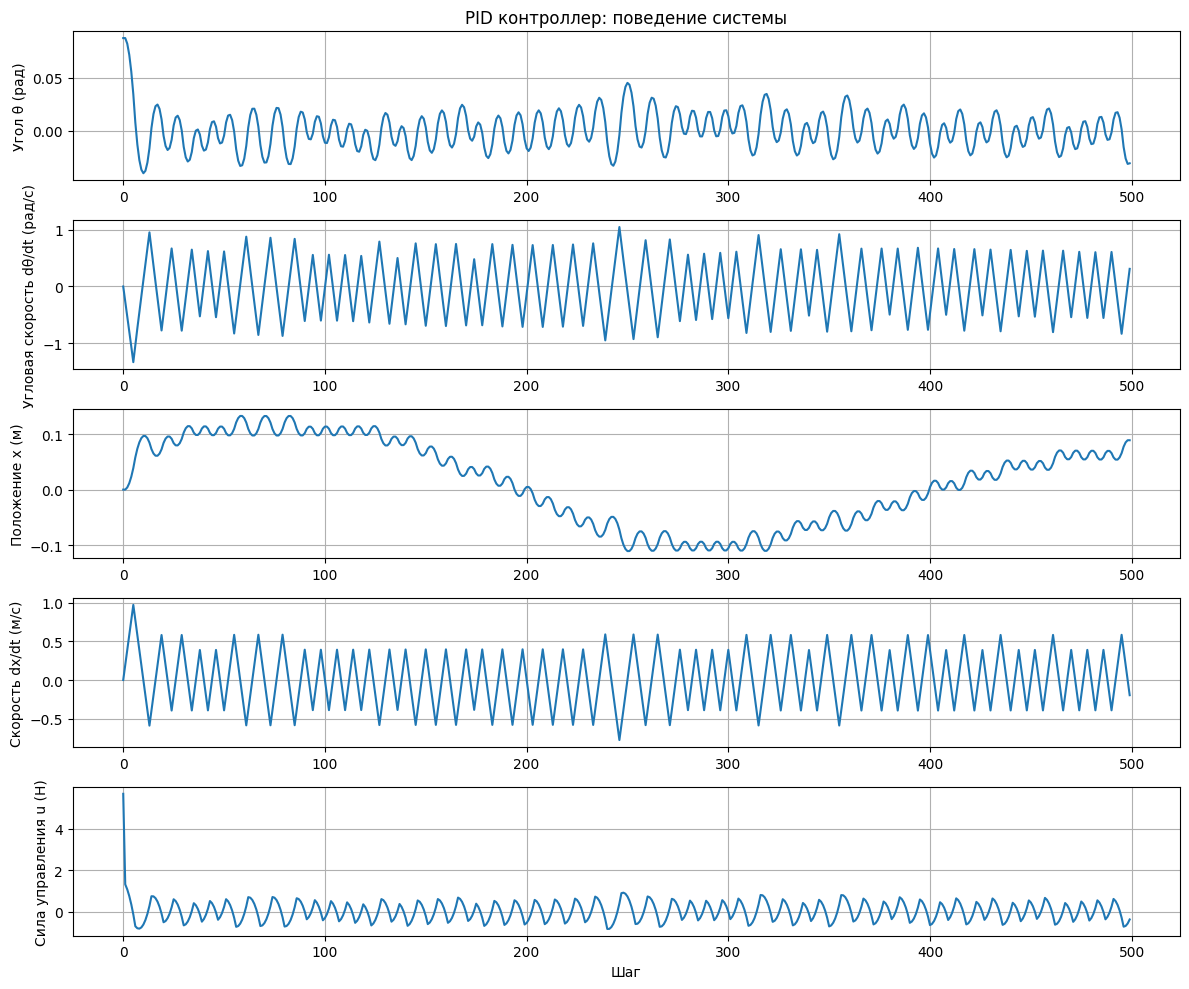

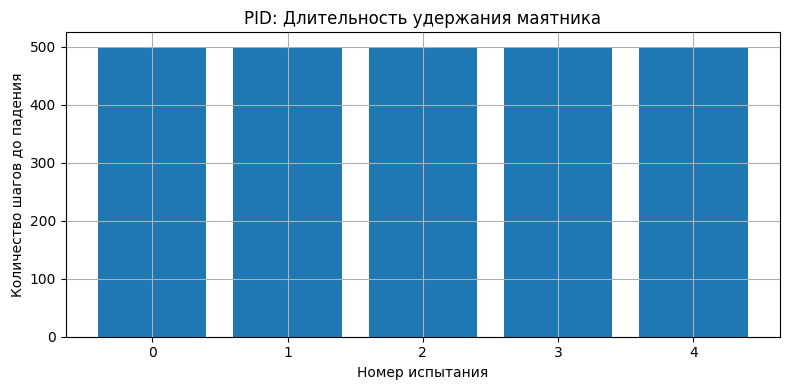

MSE для угла θ: 0.000320
MSE для положения x: 0.005769
Затраченная энергия: 121.51
Среднее количество шагов до падения: 500.00 ± 0.00


In [4]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

np.bool8 = np.bool_

# Создаем среду
env = gym.make("CartPole-v1", render_mode=None, max_episode_steps=1000)

# Параметры PID-регулятора
# Для угла
# Kp_theta = 100
Kp_theta = 15
# Ki_theta = 1
Ki_theta = 0.1
# Kd_theta = 25
Kd_theta = 1.0

# Для положения тележки
# Kp_x = 5
Kp_x = 0.5
# Ki_x = 0.1
Ki_x = 0.05
# Kd_x = 2
Kd_x = 0.5

# Функция для сбора данных о работе контроллера
def collect_pid_data(initial_angle=5, trials=5, steps=500):
    data = {
        'trial': [], 'step': [], 'x': [], 'x_dot': [], 
        'theta': [], 'theta_dot': [], 'action': [], 'force': []
    }
    
    trial_lengths = []
    
    for trial in range(trials):
        # Сброс среды
        obs, _ = env.reset()
        
        # Установка начального угла (в градусах)
        custom_state = np.array([0.0, 0.0, np.deg2rad(initial_angle), 0.0])
        env.unwrapped.state = custom_state.copy() 
        obs = custom_state.copy()
        
        # PID переменные
        int_theta = 0
        int_x = 0
        prev_theta_error = 0
        prev_x_error = 0
        dt = 0.02  # шаг времени, как в Gym
        
        for step in range(steps):
            x, x_dot, theta, theta_dot = obs
            
            # --- PID по углу ---
            error_theta = -theta  # Знак минус, т.к. мы хотим удержать маятник вверху (theta=0)
            int_theta += error_theta * dt
            d_theta = (error_theta - prev_theta_error) / dt
            prev_theta_error = error_theta
            
            u_theta = Kp_theta * error_theta + Ki_theta * int_theta + Kd_theta * d_theta
            
            # --- PID по положению ---
            error_x = -x  # Хотим удержать тележку в центре (x=0)
            int_x += error_x * dt
            d_x = (error_x - prev_x_error) / dt
            prev_x_error = error_x
            
            u_x = Kp_x * error_x + Ki_x * int_x + Kd_x * d_x
            
            # --- Общий управляющий сигнал ---
            u = -(u_theta + u_x)  # Знак можно подогнать под нужный
            force = float(np.clip(u, -10, 10))
            
            # Переводим в дискретное действие
            action = 0 if force < 0 else 1
            
            # Выполняем шаг
            obs, reward, terminated, truncated, _ = env.step(action)
            
            # Сохраняем данные
            data['trial'].append(trial)
            data['step'].append(step)
            data['x'].append(x)
            data['x_dot'].append(x_dot)
            data['theta'].append(theta)
            data['theta_dot'].append(theta_dot)
            data['action'].append(action)
            data['force'].append(force)
            
            if terminated or truncated:
                trial_lengths.append(step + 1)
                break
        
        if len(trial_lengths) <= trial:
            trial_lengths.append(steps)
    
    # Преобразуем данные в DataFrame
    df = pd.DataFrame(data)
    return df, trial_lengths

# Визуализация работы PID контроллера
def visualize_pid_performance(df, trial_lengths, save_path=None):
    # Выберем данные первого прогона для графиков
    trial_data = df[df['trial'] == 0]
    
    # Создаем фигуру
    fig, axs = plt.subplots(5, 1, figsize=(12, 10))
    
    # Угол отклонения маятника
    axs[0].plot(trial_data['step'], trial_data['theta'])
    axs[0].set_ylabel('Угол θ (рад)')
    axs[0].set_title('PID контроллер: поведение системы')
    axs[0].grid(True)
    
    # Угловая скорость маятника
    axs[1].plot(trial_data['step'], trial_data['theta_dot'])
    axs[1].set_ylabel('Угловая скорость dθ/dt (рад/с)')
    axs[1].grid(True)
    
    # Положение тележки
    axs[2].plot(trial_data['step'], trial_data['x'])
    axs[2].set_ylabel('Положение x (м)')
    axs[2].grid(True)
    
    # Скорость тележки
    axs[3].plot(trial_data['step'], trial_data['x_dot'])
    axs[3].set_ylabel('Скорость dx/dt (м/с)')
    axs[3].grid(True)
    
    # Управляющее воздействие
    axs[4].plot(trial_data['step'], trial_data['force'])
    axs[4].set_xlabel('Шаг')
    axs[4].set_ylabel('Сила управления u (Н)')
    axs[4].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
    # Показать статистику по длительности испытаний
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(trial_lengths)), trial_lengths)
    plt.xlabel('Номер испытания')
    plt.ylabel('Количество шагов до падения')
    plt.title('PID: Длительность удержания маятника')
    plt.grid(True)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_trials.png'))
    plt.show()
    
    # Расчет статистик
    mse_theta = np.mean(trial_data['theta']**2)
    mse_x = np.mean(trial_data['x']**2)
    energy = np.sum(trial_data['force']**2)
    
    print(f"MSE для угла θ: {mse_theta:.6f}")
    print(f"MSE для положения x: {mse_x:.6f}")
    print(f"Затраченная энергия: {energy:.2f}")
    print(f"Среднее количество шагов до падения: {np.mean(trial_lengths):.2f} ± {np.std(trial_lengths):.2f}")

# Собираем данные для PID
pid_data, pid_trial_lengths = collect_pid_data(initial_angle=5, trials=5)

# Визуализируем результаты
visualize_pid_performance(pid_data, pid_trial_lengths, save_path="pid_performance.png")

# Демонстрация с рендерингом
def demonstrate_pid(initial_angle=5, steps=200):
    env_render = gym.make("CartPole-v1", render_mode="human", max_episode_steps=1000)
    obs, _ = env_render.reset()
    
    # Установка начального угла (в градусах)
    custom_state = np.array([0.0, 0.0, np.deg2rad(initial_angle), 0.0])
    env_render.unwrapped.state = custom_state.copy()
    obs = custom_state.copy()
    
    # PID переменные
    int_theta = 0
    int_x = 0
    prev_theta_error = 0
    prev_x_error = 0
    dt = 0.02  # шаг времени, как в Gym
    
    for step in range(steps):
        x, x_dot, theta, theta_dot = obs
        
        # --- PID по углу ---
        error_theta = -theta  # Знак минус, т.к. мы хотим удержать маятник вверху (theta=0)
        int_theta += error_theta * dt
        d_theta = (error_theta - prev_theta_error) / dt
        prev_theta_error = error_theta
        
        u_theta = Kp_theta * error_theta + Ki_theta * int_theta + Kd_theta * d_theta
        
        # --- PID по положению ---
        error_x = -x  # Хотим удержать тележку в центре (x=0)
        int_x += error_x * dt
        d_x = (error_x - prev_x_error) / dt
        prev_x_error = error_x
        
        u_x = Kp_x * error_x + Ki_x * int_x + Kd_x * d_x
        
        # --- Общий управляющий сигнал ---
        u = -(u_theta + u_x)  # Знак можно подогнать под нужный
        force = float(np.clip(u, -10, 10))
        
        # Переводим в дискретное действие
        action = 0 if force < 0 else 1
        
        # Выполняем шаг
        obs, reward, terminated, truncated, _ = env_render.step(action)
        env_render.render()
        time.sleep(0.02)  # Замедлим для лучшей визуализации
        
        if terminated or truncated:
            break
    
    env_render.close()

# Запуск демонстрации PID (раскомментируйте при необходимости)
# demonstrate_pid(initial_angle=10)

# Тест на робастность - различные начальные углы
def test_pid_robustness(angles=None):
    if angles is None:
        angles = [2, 5, 10, 15, 20]
    
    results = []
    
    for angle in angles:
        data, trial_lengths = collect_pid_data(initial_angle=angle, trials=3)
        avg_length = np.mean(trial_lengths)
        mse_theta = np.mean(data[data['trial'] == 0]['theta']**2)
        
        results.append({
            'angle': angle,
            'avg_steps': avg_length,
            'mse_theta': mse_theta
        })
    
    # Создаем графики
    results_df = pd.DataFrame(results)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(results_df['angle'], results_df['avg_steps'], 'o-')
    ax1.set_xlabel('Начальный угол (градусы)')
    ax1.set_ylabel('Среднее количество шагов до падения')
    ax1.set_title('Робастность PID к начальным условиям')
    ax1.grid(True)
    
    ax2.plot(results_df['angle'], results_df['mse_theta'], 'o-')
    ax2.set_xlabel('Начальный угол (градусы)')
    ax2.set_ylabel('MSE угла θ')
    ax2.set_title('Ошибка стабилизации при разных начальных углах')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig("pid_robustness.png")
    plt.show()
    
    return results_df

'''
pid_robustness_results = test_pid_robustness()

def compare_controllers(pid_data, lqr_data, pid_trials, lqr_trials):
    pid_first = pid_data[pid_data['trial'] == 0]
    lqr_first = lqr_data[lqr_data['trial'] == 0]
    
    min_length = min(len(pid_first), len(lqr_first))
    pid_first = pid_first.iloc[:min_length]
    lqr_first = lqr_first.iloc[:min_length]
    
    fig, axs = plt.subplots(4, 1, figsize=(12, 10))
    
    axs[0].plot(pid_first['step'], pid_first['theta'], label='PID')
    axs[0].plot(lqr_first['step'], lqr_first['theta'], label='LQR')
    axs[0].set_ylabel('Угол θ (рад)')
    axs[0].set_title('Сравнение PID и LQR контроллеров')
    axs[0].grid(True)
    axs[0].legend()
    
    axs[1].plot(pid_first['step'], pid_first['x'], label='PID')
    axs[1].plot(lqr_first['step'], lqr_first['x'], label='LQR')
    axs[1].set_ylabel('Положение x (м)')
    axs[1].grid(True)
    axs[1].legend()
    
    axs[2].plot(pid_first['step'], pid_first['force'], label='PID')
    axs[2].plot(lqr_first['step'], lqr_first['force'], label='LQR')
    axs[2].set_ylabel('Сила управления u (Н)')
    axs[2].grid(True)
    axs[2].legend()
    
    axs[3].bar(['PID', 'LQR'], [np.mean(pid_trials), np.mean(lqr_trials)])
    axs[3].set_ylabel('Среднее кол-во шагов')
    axs[3].set_xlabel('Тип контроллера')
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.savefig("controller_comparison.png")
    plt.show()
    
    pid_mse_theta = np.mean(pid_first['theta']**2)
    lqr_mse_theta = np.mean(lqr_first['theta']**2)
    
    pid_mse_x = np.mean(pid_first['x']**2)
    lqr_mse_x = np.mean(lqr_first['x']**2)
    
    pid_energy = np.sum(pid_first['force']**2)
    lqr_energy = np.sum(lqr_first['force']**2)
    
    print("Сравнение метрик производительности:")
    print(f"MSE угла (PID): {pid_mse_theta:.6f}, MSE угла (LQR): {lqr_mse_theta:.6f}")
    print(f"MSE положения (PID): {pid_mse_x:.6f}, MSE положения (LQR): {lqr_mse_x:.6f}")
    print(f"Энергия (PID): {pid_energy:.2f}, Энергия (LQR): {lqr_energy:.2f}")
    print(f"Среднее кол-во шагов (PID): {np.mean(pid_trials):.2f}, (LQR): {np.mean(lqr_trials):.2f}")

# Сравнение контроллеров
# compare_controllers(pid_data, lqr_data, pid_trial_lengths, lqr_trial_lengths)
'''

# Завершение
env.close()